In [3]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import math
from datetime import datetime, timedelta, time, date
from sklearn.svm import SVR
from sklearn.cluster import KMeans
%matplotlib inline

In [4]:
# 使用一个trick：比较训练集和测试集每天的特征（即每个收费站在每20分钟的流量）的相似度
# 从训练集中选取和测试集合天数中最相近的那一天，作为预测集合
# 进而用选取的训练集的8~10/17~19点的数据作为最终预测集合

In [5]:
# using KNN to predict
train_path = '../dataset/training/trajectories(table 5)_training.csv'
test_path = '../dataset/testing_phase1/trajectories(table 5)_test1.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [8]:
# from 7-19 to 10-17
# print (date(2016,10,17)-date(2016,7,19)).days+1 = 91
NUM_TRAIN_DAYS = 91

# from 10-18 to 10-24
NUM_TSET_DAYS = 7

91


In [9]:
train_df.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [10]:
test_df.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,A,2,1026631,2016-10-18 06:00:14,110#2016-10-18 06:00:14#7.65;123#2016-10-18 06...,27.54
1,C,3,1017312,2016-10-18 06:00:28,115#2016-10-18 06:00:28#9.35;102#2016-10-18 06...,139.53
2,A,2,1044671,2016-10-18 06:03:07,110#2016-10-18 06:03:07#7.22;123#2016-10-18 06...,26.01
3,A,3,1000017,2016-10-18 06:04:37,110#2016-10-18 06:04:37#7.39;123#2016-10-18 06...,78.40
4,A,2,1002850,2016-10-18 06:10:17,110#2016-10-18 06:10:17#14.33;123#2016-10-18 0...,71.00


In [17]:
def per_20min(dt):
    minute = int(math.floor(dt.minute / 20) * 20)
    second = 0
    dt_new = datetime(dt.year, dt.month, dt.day, dt.hour,minute, 0)
    return dt_new

def select_time(df):
    df.starting_time = pd.to_datetime(df.starting_time)
    df['starting_time'] = df.starting_time.apply(
        per_20min)
    if {'vehicle_id','travel_seq'}.issubset(df.columns):
        df = df.drop(['vehicle_id','travel_seq'], axis=1)
    df = df.groupby(['intersection_id', 'tollgate_id', 'starting_time']).mean()
    df = df.reset_index()
    df = df.rename_axis({'travel_time':'avg_travel_time'}, axis='columns')
    hour = df.starting_time.dt.hour
    df = df.loc[((hour >= 6) & (hour < 10)) 
                     | ((hour >= 15) & (hour < 19))]
    return df

def slice_time(df):
    hour = df.starting_time.dt.hour  
    df_prev2h = df.loc[(((hour >= 6) & (hour < 8)) | ((hour >= 15) & (hour < 17)))]
    df_follow2h = df.loc[(((hour >= 8) & (hour < 10)) | ((hour >= 17) & (hour < 19)))]
    return df_prev2h, df_follow2h

def complete_miss_time(df):
    start_day = df.starting_time.dt.date.values[0]
    end_day = df.starting_time.dt.date.values[-1]
    inter_toll = [('A',2), ('A',3), ('B',1), ('B',3), ('C',1), ('C',3)]
    hour_min = [(6,0), (6,20), (6,40), (7,0), (7,20), (7,40),
              (8,0), (8,20), (8,40), (9,0), (9,20), (9,40),
              (15,0), (15,20), (15,40), (16,0), (16,20), (16,40),
              (17,0), (17,20), (17,40), (18,0), (18,20), (18,40)]
    
    df_comp = pd.DataFrame(columns=['intersection_id', 'tollgate_id',
                                    'starting_time','avg_travel_time'])
    for d in range((end_day - start_day).days+1):
        for i in range(len(inter_toll)):
            inter, toll= inter_toll[i]
            for j in range(len(hour_min)):
                h, m = hour_min[j]
                day = start_day + timedelta(days=d)
                day_time = datetime(day.year, day.month, day.day, h, m, 0)
                index = ((df.intersection_id == inter) & (df.tollgate_id == toll) &
                    (df.starting_time == day_time))
                avg_travel_time = df.loc[index].avg_travel_time
                if (not avg_travel_time.empty):
                    avg = avg_travel_time.values[0]
                else:
                    avg = np.NaN
                row = {'intersection_id': inter, 'tollgate_id': toll,
                       'starting_time': str(day_time), 'avg_travel_time':avg} 
                df_comp = df_comp.append(row, ignore_index=True)
    
    df_comp['tollgate_id'] = df_comp['tollgate_id'].astype(int)
    df_comp.starting_time = pd.to_datetime(df_comp.starting_time)
    df_comp['avg_travel_time'] = df_comp.avg_travel_time.fillna(
        df_comp.avg_travel_time.mean())
    return df_comp



# 根据KNN分类
def generate_knn_features(df):
    # 分别给月，天，时，分权重...
    features_am = pd.DataFrame(columns=[range(0,36)])
    features_pm = pd.DataFrame(columns=[range(0,36)])
    
    start_day = df.starting_time.dt.date.values[0]
    end_day = df.starting_time.dt.date.values[-1]
    
    for d in range((end_day - start_day).days+1):
        day = start_day + timedelta(days=d)
        day_time_am = [datetime(day.year, day.month, day.day, 6,0,0),
                       datetime(day.year, day.month, day.day, 8,0,0)] 
        day_time_pm = [datetime(day.year, day.month, day.day, 15,0,0),
                       datetime(day.year, day.month, day.day, 17,0,0)] 
        df_avg_am = df.avg_travel_time.loc[((df.starting_time >= day_time_am[0])
                               & (df.starting_time < day_time_am[1]))]
        df_avg_pm = df.avg_travel_time.loc[((df.starting_time >= day_time_pm[0])
                               & (df.starting_time < day_time_pm[1]))]
        row_am = list(df_avg_am.values)
        row_pm =list(df_avg_pm.values)
        features_am.loc[d] = row_am
        features_pm.loc[d] = row_pm
    return features_am, features_pm


In [13]:
train_df = select_time(train_df)
test_df = select_time(test_df)

In [14]:
# 数据对比完毕，和官方教程一致
print train_df.shape[0]
train_df.head(10)

10194


,intersection_id,tollgate_id,starting_time,avg_travel_time
13,A,2,2016-07-19 06:00:00,46.356000
14,A,2,2016-07-19 06:20:00,48.588000
15,A,2,2016-07-19 06:40:00,66.642500
16,A,2,2016-07-19 07:00:00,64.681000
17,A,2,2016-07-19 07:20:00,85.676000
18,A,2,2016-07-19 07:40:00,58.968889
19,A,2,2016-07-19 08:00:00,81.602857
20,A,2,2016-07-19 08:20:00,80.207857
21,A,2,2016-07-19 08:40:00,63.448462
22,A,2,2016-07-19 09:00:00,78.051176


In [18]:
train_df_comp = complete_miss_time(train_df)
test_df_comp = complete_miss_time(test_df)
test_prev2h, none = slice_time(test_df_comp)

In [19]:
print train_df_comp.shape[0]
print test_prev2h.shape[0]

train_df_comp.head()

13104
504


,intersection_id,tollgate_id,starting_time,avg_travel_time
0,A,2,2016-07-19 06:00:00,46.3560
1,A,2,2016-07-19 06:20:00,48.5880
2,A,2,2016-07-19 06:40:00,66.6425
3,A,2,2016-07-19 07:00:00,64.6810
4,A,2,2016-07-19 07:20:00,85.6760


In [20]:
train_prev2h, train_follow2h = slice_time(train_df_comp)

In [38]:
print train_prev2h.shape[0]
print train_follow2h.shape[0]
train_prev2h.head(20)
# train_follow2h.head(20)

6552
6552


,intersection_id,tollgate_id,starting_time,avg_travel_time
0,A,2,2016-07-19 06:00:00,46.356000
1,A,2,2016-07-19 06:20:00,48.588000
2,A,2,2016-07-19 06:40:00,66.642500
3,A,2,2016-07-19 07:00:00,64.681000
4,A,2,2016-07-19 07:20:00,85.676000
5,A,2,2016-07-19 07:40:00,58.968889
12,A,2,2016-07-19 15:00:00,79.420833
13,A,2,2016-07-19 15:20:00,72.314000
14,A,2,2016-07-19 15:40:00,58.741000
15,A,2,2016-07-19 16:00:00,59.637500


In [22]:
print test_prev2h.shape[0]
test_prev2h.head(30)

504


,intersection_id,tollgate_id,starting_time,avg_travel_time
0,A,2,2016-10-18 06:00:00,41.097143
1,A,2,2016-10-18 06:20:00,43.681667
2,A,2,2016-10-18 06:40:00,68.024286
3,A,2,2016-10-18 07:00:00,52.608333
4,A,2,2016-10-18 07:20:00,56.165556
5,A,2,2016-10-18 07:40:00,63.598571
12,A,2,2016-10-18 15:00:00,99.960667
13,A,2,2016-10-18 15:20:00,88.360556
14,A,2,2016-10-18 15:40:00,74.886000
15,A,2,2016-10-18 16:00:00,63.302727


In [23]:
train_features_am, train_features_pm = generate_knn_features(train_prev2h)
test_features_am, test_features_pm = generate_knn_features(test_prev2h)

In [39]:
print train_features_am.shape[0]
print train_features_pm.shape[0]
print train_features_am.isnull().sum().sum()
print train_features_pm.isnull().sum().sum()
train_features_am.head()


91
91
0
0


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,46.356000,48.588000,66.642500,64.681000,85.676000,58.968889,124.660000,89.846000,180.016,101.39500,...,134.560000,128.067144,128.067144,180.110000,128.067144,161.740000,223.810000,135.920000,236.120000,128.067144
1,44.095000,59.874444,88.815000,77.847778,94.919167,73.677273,97.480000,128.067144,81.850,142.06000,...,128.067144,280.710000,128.067144,130.560000,128.067144,128.067144,128.067144,223.970000,424.790000,175.090000
2,63.176667,87.030000,65.336667,78.012000,109.729333,114.720000,128.067144,94.820000,73.185,186.26200,...,128.067144,137.276667,128.067144,128.067144,128.067144,181.130000,128.067144,128.067144,128.067144,128.067144
3,65.363333,57.038750,63.971429,132.218889,100.391765,65.348889,71.780000,103.123333,160.990,106.91000,...,171.580000,128.067144,128.067144,133.595000,128.067144,128.067144,128.067144,172.440000,259.980000,179.715000
4,329.725833,80.130000,82.557333,87.626667,86.326667,96.311818,111.206667,114.960000,172.300,173.11375,...,140.880000,160.550000,128.067144,128.067144,128.067144,207.730000,258.040000,171.945000,128.067144,143.615000


In [40]:
print test_features_am.shape[0]
print test_features_pm.shape[0]
print test_features_am.isnull().sum().sum()
print test_features_pm.isnull().sum().sum()
test_features_am.head()
# test_features_pm.head()

7
7
0
0


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,41.097143,43.681667,68.024286,52.608333,56.165556,63.598571,69.48,142.01000,233.680000,143.647500,...,147.825000,180.980000,136.510000,311.040000,139.530000,128.460905,104.420000,182.062500,128.460905,128.460905
1,40.010000,57.007273,37.412000,69.584000,100.114000,58.292143,89.51,161.63500,133.432500,139.885000,...,128.460905,147.553333,128.375000,128.460905,126.740000,128.460905,128.460905,128.460905,98.030000,128.460905
2,63.584000,49.793333,60.885000,74.073750,62.988571,75.793571,113.05,101.67000,201.201429,160.836000,...,162.362500,247.705000,128.460905,128.460905,157.020000,128.460905,128.460905,92.890000,717.250000,179.640000
3,60.932857,40.730000,48.952000,49.873333,55.851111,75.138000,112.16,112.59600,141.557500,118.982500,...,128.460905,184.695000,128.460905,168.555000,128.460905,128.460905,237.130000,138.080000,189.710000,128.460905
4,33.676250,81.566667,52.290000,51.072000,58.390000,90.938000,101.30,93.80875,118.122500,112.561667,...,165.575000,128.460905,131.620000,187.740000,128.460905,128.460905,98.620000,128.460905,169.530000,128.460905


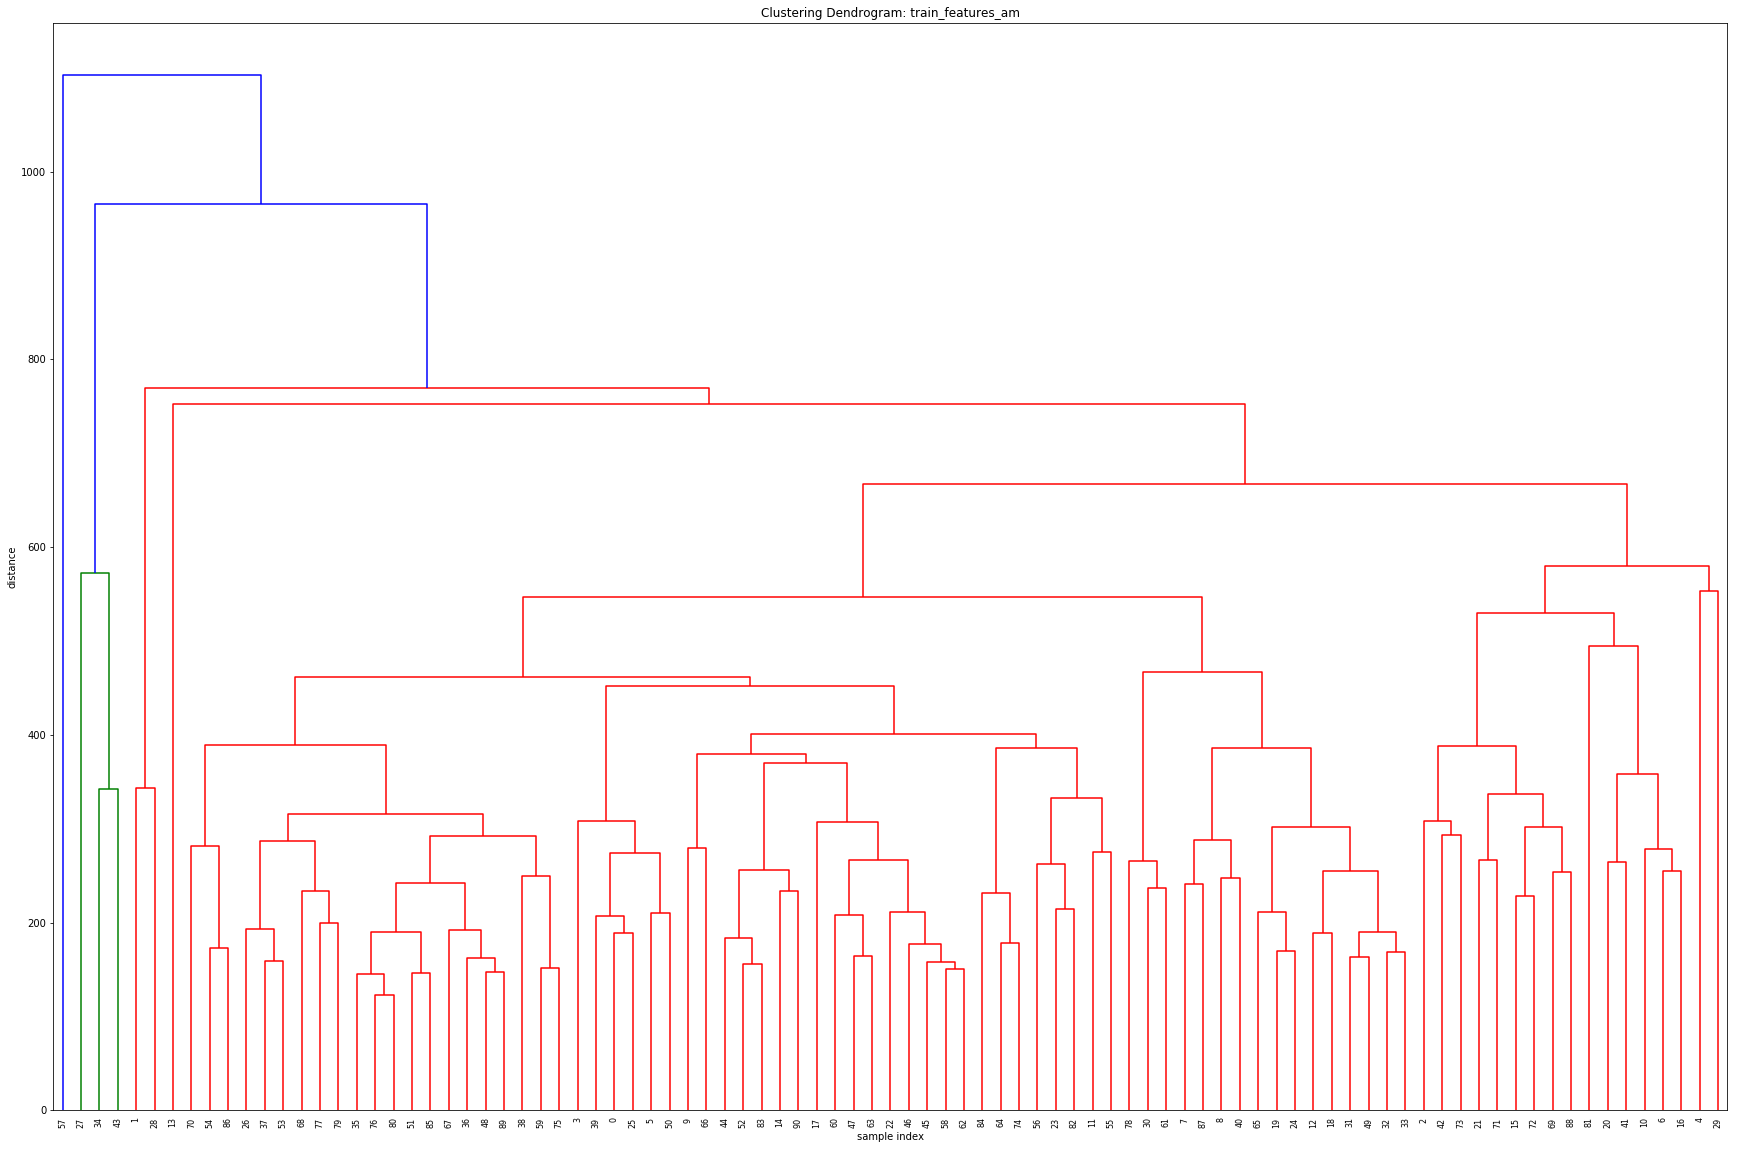

In [83]:
# 对test_features进行可视化
plt.figure(1, figsize=(30,20))
Z = linkage(train_features_am, 'ward')
plt.title('Clustering Dendrogram: train_features_am')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=91.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

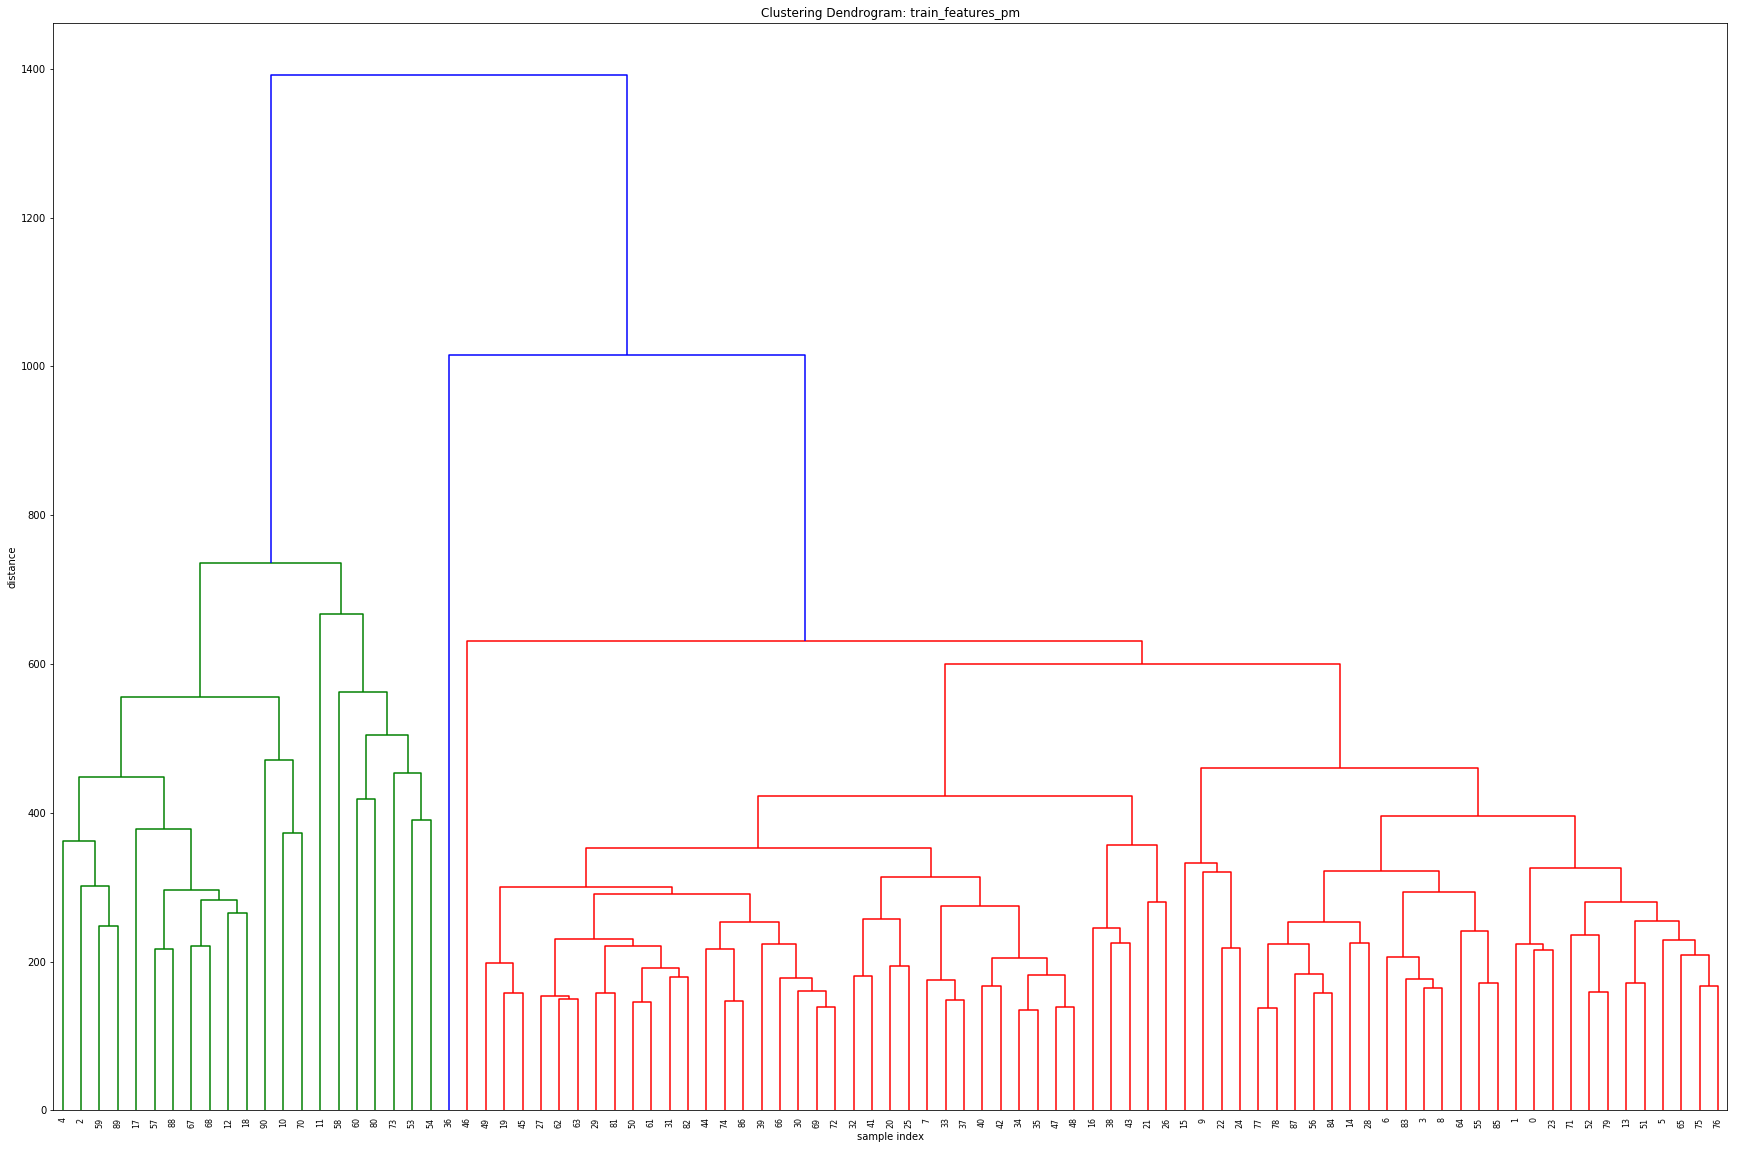

In [84]:
# 对test_features进行可视化
plt.figure(2, figsize=(30,20))
Z = linkage(train_features_pm, 'ward')
plt.title('Clustering Dendrogram: train_features_pm')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=91.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [164]:
# 类标签
kmeans_am = KMeans(n_clusters=16, random_state=0)
kmeans_am = kmeans_am.fit(train_features_am)
kmeans_pm = KMeans(n_clusters=16, random_state=0)
kmeans_pm = kmeans_pm.fit(train_features_pm)

train_labels_am = np.array(kmeans_am.labels_)
train_labels_pm = np.array(kmeans_pm.labels_)

In [165]:
print len(train_labels_am)
print len(train_labels_pm)
print train_labels_am
print train_labels_pm


91
91
[ 5  8  5  5 11  5  5  0  0  5 14  2  0 12  5  5 13  5  0  2  5 13  5 13  5
  5  5 10  8  7  6  0  0  0  4  0  0  0  5  0  0  5 15  3  5 11  5  0  0  0
  5  5  5  0 13  5  2  1  5  0 11  6  5  5  5  2  6  0  0  4 15  2 15 15  2
  0  0  2  2  0  0  9  5  5  5  5 13  5  4  0  4]
[15 15 15  1  4 15  1  1 15  9  8 13 15 15 15  9  1  9 15  1  1  1  9 15 15
  1  1 10 10 10 10  1  1 10 10 10  0 10 10 10  1  1 10 10 10 10  6 10 10  1
  1 15 15  3 14  9  9  4  7  4 11  1  1  1 15 15 15  2  2 10  4 15 15 12  1
 15 15 15  9 15  5  1  1  1 15  1  1  1  2  2 15]


In [166]:
pred_kms_am = np.array(kmeans_am.predict(test_features_am))
pred_kms_pm = np.array(kmeans_pm.predict(test_features_pm))

In [167]:
print pred_kms_am
print pred_kms_pm

[ 4  5  8  5  5  0 13]
[15 15  1 15  2  2  1]


In [172]:
# 得到KMean聚类
pred_day_am = list()
pred_day_pm = list()
for i in range(len(pred_kms_am)):
    p_am = pred_kms_am[i]
    p_pm = pred_kms_pm[i]
    pred_day_am.append(np.where(train_labels_am == p_am)[0])  
    pred_day_pm.append(np.where(train_labels_pm == p_pm)[0])

print len(pred_day_am)
print len(pred_day_am[0])

7
4


In [173]:
pred_kmeans = pd.DataFrame(columns=['intersection_id', 'tollgate_id',
                                    'starting_time','avg_travel_time'])
day_all = train_follow2h.starting_time.dt.date
start_day = day_all.values[0]
test_start_day = test_prev2h.starting_time.dt.date.values[0]
train_pd_am = pd.DataFrame()
train_pd_pm = pd.DataFrame()
train_pd = pd.DataFrame()

for i in range(len(pred_day_am)):
    pday_am, pday_pm = pred_day_am[i], pred_day_pm[i]
    for j in range(len(pday_am)):
        pd_am = pday_am[j]
        day_am = start_day + timedelta(days=pd_am)
        day_time_am = [datetime(day_am.year, day_am.month, day_am.day, 8,0,0),
                   datetime(day_am.year, day_am.month, day_am.day, 10,0,0)] 
        train_pd_am = train_pd_am.append(train_follow2h.loc[((train_follow2h.starting_time >= day_time_am[0])
                               & (train_follow2h.starting_time < day_time_am[1]))])
    for k in range(len(pday_pm)):
        pd_pm = pday_pm[k]
        day_time_pm = [datetime(day_pm.year, day_pm.month, day_pm.day, 17,0,0),
                   datetime(day_pm.year, day_pm.month, day_pm.day, 19,0,0)] 
        train_pd_pm = train_pd_pm.append(train_follow2h.loc[((train_follow2h.starting_time >= day_time_pm[0])
                               & (train_follow2h.starting_time < day_time_pm[1]))])
    day_need  = test_start_day+timedelta(days=i)
    train_pd = train_pd_am.append(train_pd_pm, ignore_index=True)
    train_pd.starting_time = train_pd.starting_time.apply(
      lambda dt: datetime(day_need.year, day_need.month, day_need.day,
                         dt.hour, dt.minute, 0))
    train_pd =  train_pd.groupby(['intersection_id', 'tollgate_id', 'starting_time']).mean()
    train_pd = train_pd.reset_index()
    pred_kmeans = pred_kmeans.append(train_pd, ignore_index=True)

pred_kmeans.starting_time = pd.to_datetime(pred_kmeans.starting_time)
pred_kmeans['tollgate_id'] = pred_kmeans['tollgate_id'].astype(int)

In [174]:
print pred_kmeans.shape[0]
pred_kmeans.head(20)

504


,intersection_id,tollgate_id,starting_time,avg_travel_time
0,A,2,2016-10-18 08:00:00,98.409028
1,A,2,2016-10-18 08:20:00,92.737776
2,A,2,2016-10-18 08:40:00,105.339945
3,A,2,2016-10-18 09:00:00,99.983003
4,A,2,2016-10-18 09:20:00,96.031900
5,A,2,2016-10-18 09:40:00,79.151969
6,A,2,2016-10-18 17:00:00,65.450357
7,A,2,2016-10-18 17:20:00,60.545357
8,A,2,2016-10-18 17:40:00,63.780556
9,A,2,2016-10-18 18:00:00,66.116667


In [175]:
# 生成对应格式的输出csv文件
test_pred = pred_kmeans
start_time= pd.to_datetime(test_pred.starting_time)
end_time = start_time.apply(lambda dt: dt + timedelta(minutes=20))
test_pred['starting_time']  = '['+ start_time.astype(np.str) + ',' + end_time.astype(np.str) + ')'
test_pred = test_pred.rename_axis({'starting_time':'time_window'}, axis='columns')
test_pred.to_csv('results/task1_kmeans.csv', index=False)
test_pred.head(20)

,intersection_id,tollgate_id,time_window,avg_travel_time
0,A,2,"[2016-10-18 08:00:00,2016-10-18 08:20:00)",98.409028
1,A,2,"[2016-10-18 08:20:00,2016-10-18 08:40:00)",92.737776
2,A,2,"[2016-10-18 08:40:00,2016-10-18 09:00:00)",105.339945
3,A,2,"[2016-10-18 09:00:00,2016-10-18 09:20:00)",99.983003
4,A,2,"[2016-10-18 09:20:00,2016-10-18 09:40:00)",96.031900
5,A,2,"[2016-10-18 09:40:00,2016-10-18 10:00:00)",79.151969
6,A,2,"[2016-10-18 17:00:00,2016-10-18 17:20:00)",65.450357
7,A,2,"[2016-10-18 17:20:00,2016-10-18 17:40:00)",60.545357
8,A,2,"[2016-10-18 17:40:00,2016-10-18 18:00:00)",63.780556
9,A,2,"[2016-10-18 18:00:00,2016-10-18 18:20:00)",66.116667


In [176]:
a = np.array([1,2,3,3,4,4,4,5,5])
b = np.where(a == 4)[0]
print b

[4 5 6]


In [178]:
print (1,0) == (1,0)

True


In [181]:
print set([1,2,2,3,4])


set([1, 2, 3, 4])


In [ ]:
for x in x_all:
    for y in y_all:
        